<a href="https://colab.research.google.com/github/GiuniorCandido/PTC-3569_Intro_ML/blob/master/BackPropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
from IPython.display import Image

In [2]:
uploaded = files.upload()

Saving ex4_ptc.png to ex4_ptc.png


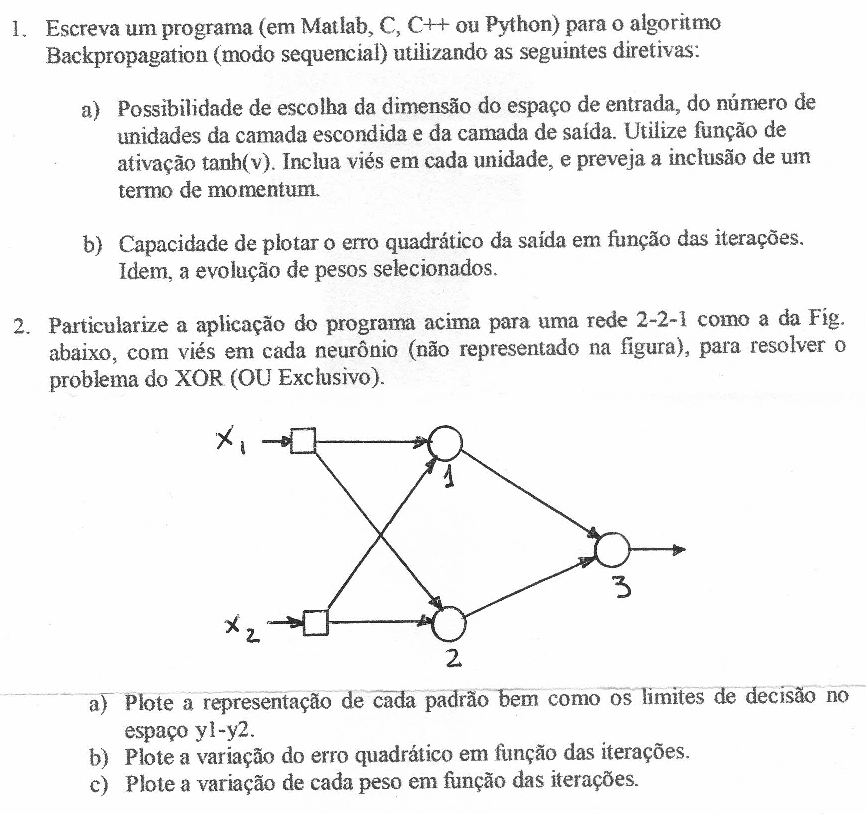

In [3]:
Image('ex4_ptc.png')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


O código abaixo implementa a construção, treinamento com gradiente descendente, e predição de uma rede neural de L camadas, com ativações tanh().

Além disso, o código mostra evolução da função de custo MSE, bem como a evolução dos valores dos pesos e viés para cada neurônio. Também plota a região de classifição e a região de regressão.

Tol achieved in iter 456.


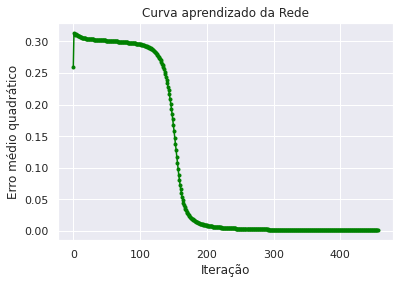

[[ 2.37675343e-03]
 [ 9.54450436e-01]
 [ 9.56690402e-01]
 [-1.98512392e-04]]


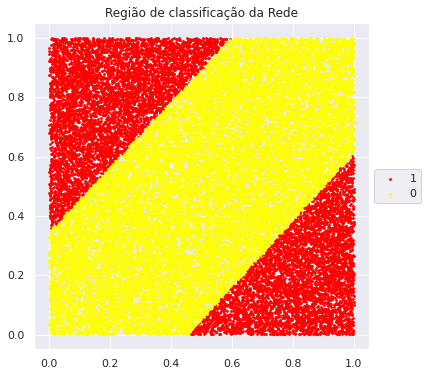

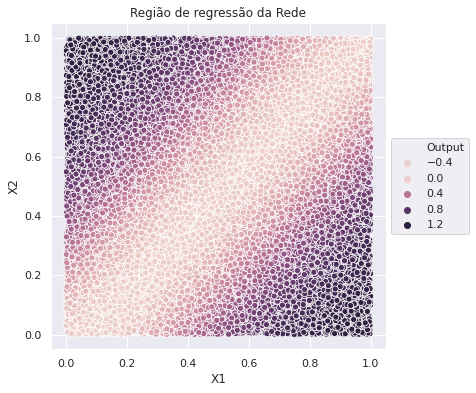

Camada 1 : 
   Neurônio 1 (1,1) 
   Neurônio 2 (1,2) 
Camada 2 : 
   Neurônio 1 (2,1) 



In [11]:
class Neuron:
    """
    Classe neurônio. Esse objeto será utilizado na classe NN.
    """
    def __init__(self, dim_input):
        """
        Método para inicialização do neurônio.

        Parameters
        ----------
        dim_input : int
            Dimensão da entrada que o neurônio vai receber.
        """
        self.w = np.random.random(dim_input + 1)*2 - 1  # Cria pesos aleatórios entre -1 e 1
        self.z = np.empty_like(self.w)                  # Momento (inicialmente nulo)
        self.func_ff = np.tanh                          # Função utilizada no feedforward
        self.func_bp = lambda x: 1/np.cosh(x)**2        # Função utilizada no backpropagation
        self.w_list = [self.w.copy()]                   # Atributo para plotar os pesos

    def _feedforward(self, sample):
        """
        Método para feedforward do neurônio.

        Parameters
        ----------
        sample : numpy.array
            Dado de entrada.
        """
        self.v = np.sum(self.w*sample)                  # Calcula e salva a tensão do neurônio
        return self.func_ff(self.v)                     # Aplica a função de feedforward

    def _grad(self, info):
        """
        Método para calculo do gradiente. Embora essa função seja
        geral para todos os neurônios (oculto ou de saída), é
        importante notar que a informação que eles recebem são
        diferentes. Para neurônio de saída, o parâmetro 'info'
        é o valor do erro daquele neurônio; enquanto que, para
        um neurônio da camada oculta, esse parâmetro é a somatória
        do produto entre o gradiente dos neurônios da próxima 
        camada e os pesos que ligam esses neurônios com o atual.

        Parameters
        ----------
        info : float
            Informação necessária para calcular o gradiente.
        """
        self.grad = info*self.func_bp(self.v)           # Calcula e salva o gradiente do neurônio       
        return self.grad*self.w[1:]                     # Retorna o produto gradiente*pesos para os outros neurônios

    def _update(self, sample, ca, cm):
        """
        Método que atualiza os pesos dos neurônios.

        Parameters
        ----------
        sample : numpy.array
            Dado de entrada do neurônio.
        ca : float
            Constante de Aprendizado.
        cm : float
            Constante de Momento.
        """
        update = cm*self.z + ca*self.grad*sample        # Cria o delta w da iteração q
        self.z = update.copy()                          # Salva esse delta w para o momento da próxima iteração
        self.w += update                                # Atualiza os pesos
        self.w_list.append(self.w.copy())
    
    def plotW(self, title, cmap='YlOrRd'):
        """
        Método que plota a evolução dos pesos e bias.

        Parameters
        ----------
        title : tuple
            Tupla indicando a posição do neurônio.
        cmap : string (default = 'YlOrRd')
            Colormap para os gráficos.
        """

        w_array = np.array(self.w_list)
        n_iter, d = w_array.shape
        x = np.arange(n_iter)

        colors = eval(f"plt.cm.{cmap}(np.linspace(0,1,d))")

        names = ["Viés"]
        names += list(map(lambda i: f"Neurônio {i}", np.arange(1,d)))

        for i in range(d):
            plt.plot(x, w_array[:,i], c=colors[i], label=names[i])
        plt.title(f"Evolução dos pesos e víes do Neurônio {title}")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("Iteração")
        plt.show()


class NN:
    """
    Classe Neural Network (NN). Essa classe utiliza a classe Neuron.
    """
    def __init__(self, shape, ca=0.2, cm=0.2):
        """
        Método de inicialização.

        Parameters
        ----------
        shape : list
            Lista possuindo a dimensão de entrada, o número de camadas/neurônios
            (essa classe funciona para qualquer tamanho) ocultas/ocultos e o 
            número de neurônios de saída.
        ca : float (default = 0.2)
            Constante de Aprendizado.
        cm : float (default = 0.2)
            Constante de Momento.
        """
        self.shape = shape                              
        self.ca = ca
        self.cm = cm
        self._createNetwork()

    def _createNetwork(self):
        """
        Método que cria a rede. Utiliza o atributo 'self.shape' criado no __init__.
        """
        net = []
        for i in range(1,len(self.shape)):
            net.append(list(map(lambda _: Neuron(self.shape[i-1]), range(self.shape[i]))))
        self.net = net

    def _feedforward(self, sample):
        """
        Método que faz o feedforward da rede. As entradas das camadas ocultas e de
        saída ficam salvas no atributo 'self.hidden_output', junto com a saída da
        rede.

        Parameters
        ----------
        sample : numpy.array
            Dado de entrada.
        """
        self.hidden_output = [sample.copy()]      
        for i in range(len(self.net)):
            output = list(map(lambda n: n._feedforward(self.hidden_output[-1]), self.net[i]))
            output = np.array([1] + output)
            self.hidden_output.append(output)
        return self.hidden_output[-1][1:]

    def _backpropagation(self, e):
        """
        Método que aplica o backpropagation nos neurônios. Os neurônios de saída 
        utilizam o seu respectivo erro para calcular seu gradiente, que vai sendo
        'passado' para os neurônios da camada anterior, que utiliza essa informação
        para calcular os seus gradientes, assim por diante.

        Parameters
        ----------
        e : numpy.array
            Array contendo os erros dos neurônios de saída.
        """
        for l in range(1, len(self.net)+1):
            layer = self.net[-l]
            if l == 1:                                  # Caso seja neurônio de saída
                grad_list = list(map(lambda i: layer[i]._grad(e[i]), np.arange(len(layer))))
            else:                                       # Caso seja neurônio escondido
                grad_list = list(map(lambda i: layer[i]._grad(grad_array[i]), np.arange(len(layer))))
            grad_array = np.sum(grad_list, axis=0)

    def _update(self):
        """
        Método que atualiza os neurônios.
        """
        for i in range(len(self.net)):
            for n in range(len(self.net[i])):
                self.net[i][n]._update(self.hidden_output[i], self.ca, self.cm)

    def fit(self, X, y, iter_max=1000, tol=1e-3):
        """
        Método que concatena todas os outros métodos para aprendizagem da rede.

        Parameters
        ----------
        X : numpy.array
            Dados de entrada. Deve possuir N linhas e D colunas, onde N é o número
            de pontos e D é a dimensão deles.
        y : numpy.array
            Dados de saída. Deve possuir N linhas e O colunas, onde N é o número
            de pontos e O é a dimensão de saída.
        iter_max : int (default = 1000)
            Número de iterações máxima.
        tol : float (default = 1e-3)
            Tolerância mínima de erro para critério de parada.
        """
        X_i = np.insert(X, 0, 1, axis=1)                # Adiciona coluna de 1 para bias
        self.error = []                                 # Atributo utilizado para plotar o erro
        for q in range(iter_max):                   
            error = 0   
            for i in range(X_i.shape[0]):
                sample = X_i[i]
                d = y[i]
                o = self._feedforward(sample)
                e = d - o                               # Calcula o erro do ponto
                error += e**2
                self._backpropagation(e)
                self._update()
            error = error/X_i.shape[0]
            self.error.append(error)
            if error < tol:                             # Verifica se alcançou a tolerância
                print(f"Tol achieved in iter {q}.")
                break

    def predict(self, X):
        """
        Método que calcula a saída de um conjunto de dados de entrada.

        Parameters
        ----------
        X : numpy.array
            Dados de entrada. Deve possuir N linhas e D colunas, onde N é o número
            de pontos e D é a dimensão deles.

        Returns
        -------
        outputs : numpy.array
            Dados de saída. Possui N linhas e O colunas, onde N seria o número de 
            pontos fornecido e O o número de neurônios de saída.
        """
        outputs = []
        X_i = np.insert(X, 0, 1, axis=1)
        for i in range(X_i.shape[0]):
            sample = X_i[i]
            outputs.append(self._feedforward(sample))
        outputs = np.array(outputs)
        return outputs

    def plotError(self):
        """
        Método que plota o erro ao longo das iterações.
        """ 
        plt.plot(np.arange(len(self.error)), self.error, marker='.', c='green')
        plt.xlabel("Iteração")
        plt.ylabel("Erro médio quadrático")
        plt.title("Curva aprendizado da Rede")
        plt.show()

    def describe(self):
        message = ""
        for i in range(len(self.net)):
            message += f"Camada {i+1} : \n"
            for j in range(len(self.net[i])):
                message += f"   Neurônio {j+1} ({i+1},{j+1}) \n"
        print(message)

    def plotNeuron(self, neurons, cmap='YlOrRd'):
        if type(neurons) is tuple:
            l,n = neurons
            neuron = self.net[l-1][n-1]
            neuron.plotW(neurons, cmap=cmap)
        else:
            for neu in neurons:
                l,n = neu
                neuron = self.net[l-1][n-1]
                neuron.plotW(neu, cmap=cmap)  

#Implementando o código para as plotagens exigidas na questão 2: 
X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])
y = np.array([0,1,1,0])


a = NN([2,2,1])
a.fit(X,y)
a.plotError()
print(a.predict(X))

data = np.random.random((30000,2))
classe = (a.predict(data) >= 0.5).astype(int).flatten()

data_0 = data[classe==0]
data_1 = data[classe==1]

plt.figure(figsize=(6,6))
plt.scatter(data_1[:,0], data_1[:,1], s=3, c='red', label='1')
plt.scatter(data_0[:,0], data_0[:,1], s=3, c='yellow', label='0')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Região de classificação da Rede")
plt.show()

df = pd.DataFrame(np.concatenate([data, a.predict(data)], axis=1), columns=['X1', 'X2', 'Output'])

plt.figure(figsize=(6,6))
sns.scatterplot(x='X1', y='X2', hue='Output', data=df)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Região de regressão da Rede")
plt.show()


a.describe()

O primeiro gráfico em verde em verde representa o item B da questão 2;

É possível verificar que método precisou de aproximadamente 300 iterações para classificar todas as amostras corretamente (o erro total é zero). Em outras palavras, o algoritmo precisava ver o conjunto de dados cerca de 300 vezes, para aprender sua estrutura.

Os dois gráficos seguintes pertecem ao item A da questão 2


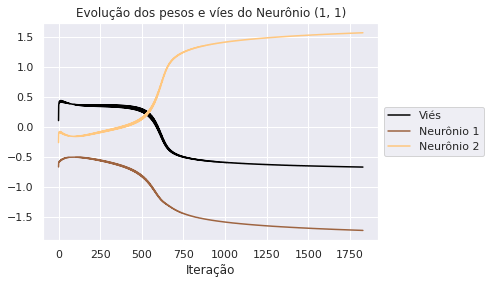

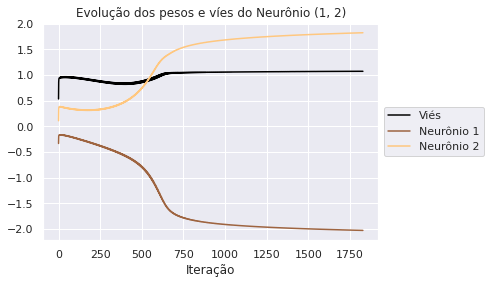

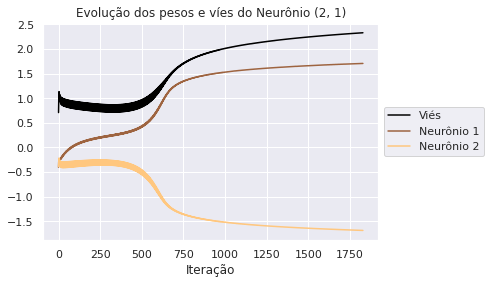

In [12]:
a.plotNeuron([(1,1), (1,2),(2,1)], 'copper')

Primeiro gráfico representa o comportamento dos pesos e do viés para o primeiro neurônio da camada 1.

Segundo gráfico representa comportamento dos pesos e do viés para o segundo neurônio da camada 1.

E o ultimo gráfico é a evolução dos pesos e do viés para o neurônio da camada 2 (neurônio de saída)